## `Course evaluation information`

- Concisely note down your observations for each lab from now on.
- You can take notes inside the notebooks, or in separate PDFs.
- Either way, be ready to show the work you putted into each lab, including the experiments and the learning outcomes.
- During the exam, you will be asked to show your notes for some of the labs at random with a brief discussion on its content

# Lab. 1: Local search

## Introduction

#### <u>The goal is to study the application of local search algorithms on different benchmark functions.</u>

We will see the following methods:
- *Grid Search*
- *Random Search*
- *Powell*
- *Nelder Mead*

Moreover, we will study how their parameters change the behavior of these algorithms.

---

Getting started: the following code cell contains the core functions that we will use. Hence, **remember to run it every time the runtime is reconnected**.

It contains the three local search algorithms and a wrapper class called *OptFun* for the benchmark function.
As regards the *OptFun* class, the constructor takes as input a benchmark function (we will see later what functions are available). The relevant methods  are 4:
1.   *Minima*: returns a list of Optimum objects of the known global minima. If there aren't any minima, an empty list value will be returned instead. For each object, the position can be obtained by the parameter *position* and the function value from the *score* parameter.
2.   *Bounds*: returns where the function is defined
3.   *Heatmap*: show a heatmap of the function highlighting the points visited by the local search (use with 2d function)
4.   *plot*: show the trend of the points visited by the local search (use with 1d function)

Each instance of *OptFun* stores the history of the point at which the function has been evaluated. The history is never cleaned and can be obtained through *OptFun.history*. Hence, if you reuse the class instance remember to clean the history (*OptFun.history = list()*).

---

The benchmark functions available comes from the *benchmark_functions* library (imported as *bf*).
Example of the functions that can be used are the *Hypersphere*, the *Rastrign* the *DeJong5* and the Keane.
The complete list of functions available can be found at this [link](https://gitlab.com/luca.baronti/python_benchmark_functions) or you can print it with *dir(bf)*.

#### Base code to run every time the runtime is reconnected

In [20]:
%%capture

try:
  import benchmark_functions as bf
except:
  !pip3 install benchmark_functions
  import benchmark_functions as bf

from scipy.optimize import minimize, rosen
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy
import inspect

plt.rcParams["figure.figsize"] = (8,5)

In [63]:
class OptFun():
    def __init__(self, wf):
        self.f = wf
        self.history = []

    def __call__(self, x0):
        self.history.append(deepcopy(x0))
        return self.f(x0)

    def minima(self):
        """
        Returns a list of Optimum objects of the known global minima. If there aren't any minima, an empty list value will be returned instead;

        Returns:
        - List of objects of class "benchmark_functions.functions_info_loader.Optimum"
        - For each object:
          - Access to 'position' parameter to get the axis values
          - Access to 'score' parameter to get the value of the function
        """
        return self.f.minima()

    def bounds(self):
        return self._convert_bounds(self.f.suggested_bounds())

    def heatmap(self, fn = None):
        plt.clf()
        resolution = 50
        fig = plt.figure()
        fig.canvas.manager.set_window_title('Benchmark Function: '+self.f._name)
        fig.suptitle(self.f._name)
        bounds_lower, bounds_upper = self.f.suggested_bounds()
        x = np.linspace(bounds_lower[0], bounds_upper[0], resolution)
        if self.f._n_dimensions>1:
            y = np.linspace(bounds_lower[1], bounds_upper[1], resolution)
            X, Y = np.meshgrid(x, y)
            Z = np.asarray([[self.f((X[i][j],Y[i][j])) for j in range(len(X[i]))] for i in range(len(X))])

        plt.contour(x,y,Z,15,linewidths=0.5,colors='k') # hight lines
        plt.contourf(x,y,Z,15,cmap='viridis', vmin=Z.min(), vmax=Z.max()) # heat map
        plt.xlabel('x')
        plt.ylabel('y')
        cbar = plt.colorbar()
        cbar.set_label('z')
        if len(self.history)>0:	# plot points
            xdata = [x[0] for x in self.history]
            ydata = [x[1] for x in self.history]
            plt.plot(xdata, ydata, "or-", markersize=2, linewidth=2)
        if fn is None:
            plt.show()
        else:
            plt.savefig(fn, dpi=400)

    def plot(self):
        plt.clf()
        values = [self.f(v) for v in self.history]
        min = func.minima()[0].score
        plt.plot(values, label="trend of found points")
        plt.axhline(min, color="r", label="optimum")
        plt.xlabel('Iterations')
        plt.ylabel('f(x)')
        plt.legend()
        plt.show()

    def _convert_bounds(self, bounds):
        new_bounds= []
        for i in range(len(bounds[0])):
            new_bounds.append((bounds[0][i], bounds[1][i]))
        return new_bounds

    def current_calls(self):
        return len(self.history)

def grid_search(f: OptFun, step_size=None, number_of_steps=None, minimization=True):
    """
    Optimizes a function by using the grid_search algorithm.

    - f: function to optimize, an instance of OptFun
    - step_size: the step size
    - number_of_steps: the total number of steps
    - minimization: boolean, True if looking for minimum, False if looking for maximum; defauls True

    Returns:
    - best value found
    """

    if (step_size != None):
      range_step_size = step_size
    elif (number_of_steps != None):
        range_step_size = int(np.floor(np.sqrt(number_of_steps)))
    else:
        print("Please provide at least the step_size or the number_of_steps")
        return

    bounds = f.bounds()
    best = float('inf') if minimization else float('sup')

    for x in np.arange(bounds[0][0], bounds[0][1], range_step_size):
      for y in np.arange(bounds[1][0], bounds[1][1], range_step_size):
        current = f([x, y])
        if minimization:
          if current < best:
            best = current
        else:
          if current > best:
            best = current

    return best

def random_search(f: OptFun, n_samples_drawn, minimization=True):
    """
    Optimizes a function by using the random_search algorithm.

    - f: function to optimize, an instance of OptFun
    - number_of_steps: the total number of steps
    - minimization: boolean, True if looking for minimum, False if looking for maximum; defauls True

    Returns:
    - best value found
    """

    bounds = f.bounds()
    best = float('inf') if minimization else float('sup')
    for i in range(n_samples_drawn):
      x = np.random.uniform(bounds[0][0], bounds[0][1])
      y = np.random.uniform(bounds[1][0], bounds[1][1])
      current = f([x, y])
      if minimization:
        if current < best:
          best = current
      else:
        if current > best:
          best = current

    return best

def powell(f: OptFun, x0, maxiter: int):
    """
    Optimizes a function by using the Powell algorithm.

    - f: function to optimize, an instance of OptFun
    - x0: starting point for the search process
    - maxiter: maximum number of iterations
    """
    bounds = f.bounds()
    results = minimize(fun=f, x0=list(x0), method="powell", bounds=bounds,
                       options={"ftol":1e-4,
                                "maxfev": None,
                                "maxiter": maxiter,
                                "return_all":True})
    return results

def nelder_mead(f: OptFun, x0, maxiter: int):
    """
    Optimizes a function by using the Nelder-Mead algorithm.

    - f: function to optimize, an instance of OptFun
    - x0: starting point for the search process
    - maxiter: maximum number of iterations
    """
    bounds = f.bounds()
    return minimize(
        f,
        x0,
        method='Nelder-Mead',
        tol=None,
        bounds=bounds,
        options={
            "maxfev": None,
            "maxiter": maxiter,
            'disp': False,
            'return_all': True,
            'initial_simplex': None,
            'xatol': 0.000,
            'fatol': 0.000,
            'adaptive': False
        }
    )

In [28]:

def printClassInitArgs(class_obj):
    signature = inspect.signature(class_obj.__init__).parameters
    print("-------------------------------")
    for name, parameter in signature.items():
        print("Name: ", name, "\nDefault value:", parameter.default)
        #print("Annotation:", parameter.annotation, "\nKind:", parameter.kind)
        print("-------------------------------")

# Exercises

#### Solve the following exercises, and answer these questions at the end:

- How the benchmark functions influence the optimization algorithms? There is an algorithm which is always better than the other?
- The choiche of the parameters is influenced by the function to optimize? And how the algorithm are influenced by the parameters?

In [34]:
# BE AWARE: check the arguments each benchmark function takes and ignore the "opposite" argument
# if you're not sure, you can check the arguments by using the printClassInitArgs function
printClassInitArgs(bf.DeJong5())

printClassInitArgs(bf.Hypersphere())


-------------------------------
Name:  opposite 
Default value: False
-------------------------------
-------------------------------
Name:  n_dimensions 
Default value: 2
-------------------------------
Name:  opposite 
Default value: False
-------------------------------


## Exercise 1/4: GRID SEARCH
In this first exercise we will use grid search as a search algorithm

### Questions
- How does the step size influence the quality of the best point obtained?
- How does the step size influence the search cost?

Bounds: [(-5.0, 5.0), (-5.0, 5.0)]
Best value: 0.0


<Figure size 800x500 with 0 Axes>

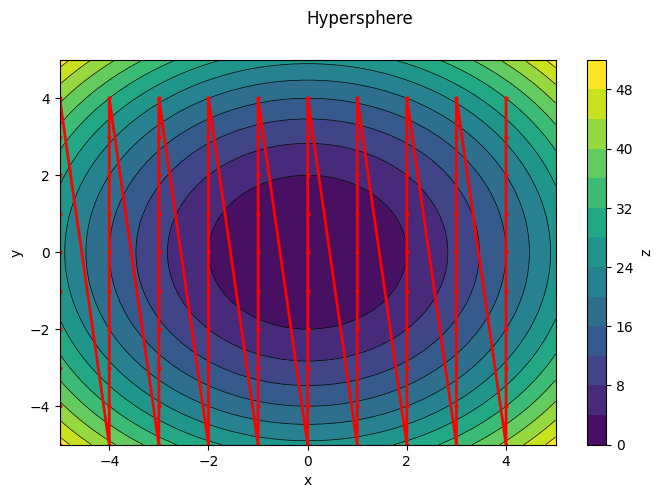

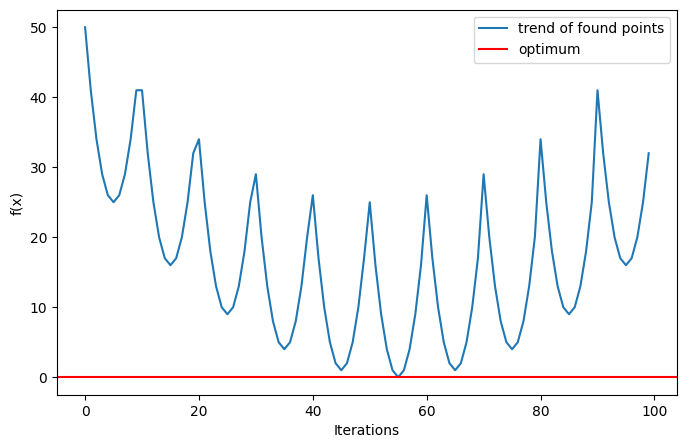

In [69]:
bench_func = bf.Hypersphere(n_dimensions=2) #TODO: try differenct benchmark function
func = OptFun(bench_func)
print("Bounds:", func.bounds())

step_size = 1  # TODO: try different step_size values (e.g.: [0.5, 1, 3]), coherent with the function bounds

best = grid_search(func, step_size=step_size)
print("Best value:", best)

func.heatmap()
func.plot()

## Exercise 2/4: RANDOM SEARCH

In this exercise we will use Random Search to search for the optimum

### Questions
- How does the number of samples drawn affect the search?
- How does this method compare to Grid Search? What are the advantages and disadvantages?

Bounds: [(-5.0, 5.0), (-5.0, 5.0)]
Best value: 0.1332089722555842


<Figure size 800x500 with 0 Axes>

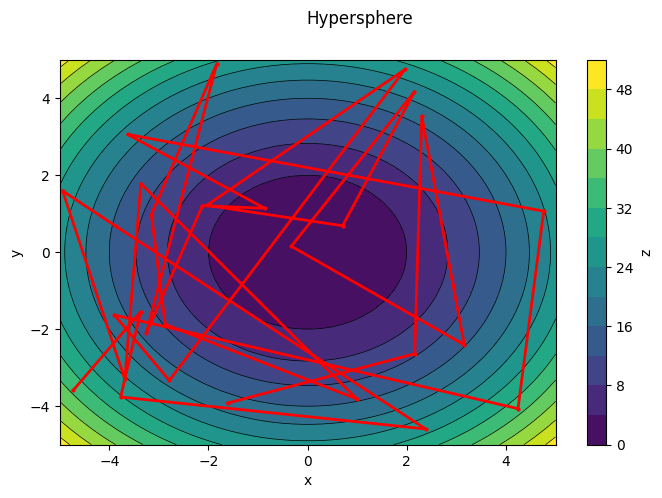

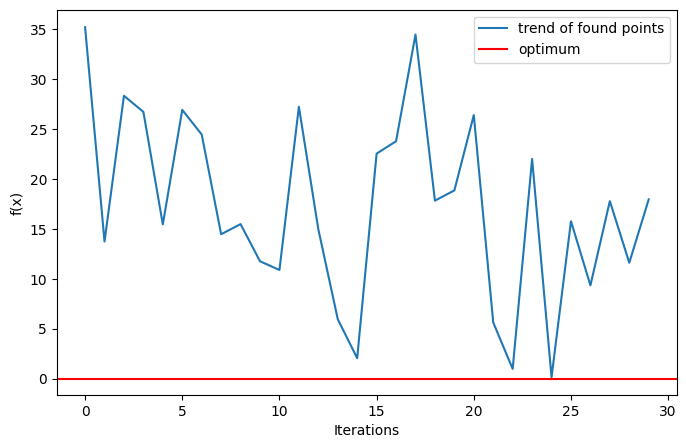

In [68]:
bench_func = bf.Hypersphere(n_dimensions=2) #TODO: try differenct benchmark function
func = OptFun(bench_func)
print("Bounds:", func.bounds())

n_samples_drawn = 30  # TODO: try different values (e.g.: [3, 30, 50])

best = random_search(func, n_samples_drawn)
print("Best value:", best)

func.heatmap()
func.plot()

In [6]:
# TODO: compare to Grid Search

## Exercise 3/4: POWELL OPTIMIZATION

In this exercise we will focus on the Powel optimization algorithm.

### Questions
- What happens when varying the parameters of the algorithm?
- How they influence the optimization process?
- The effects of these parameters is the same across different functions?
- How does this algorithm compare to the previous?

Bounds: [(-5.0, 5.0), (-5.0, 5.0)]
Best solution: [-8.8817842e-16  0.0000000e+00]
Best value: 7.888609052210118e-31


<Figure size 800x500 with 0 Axes>

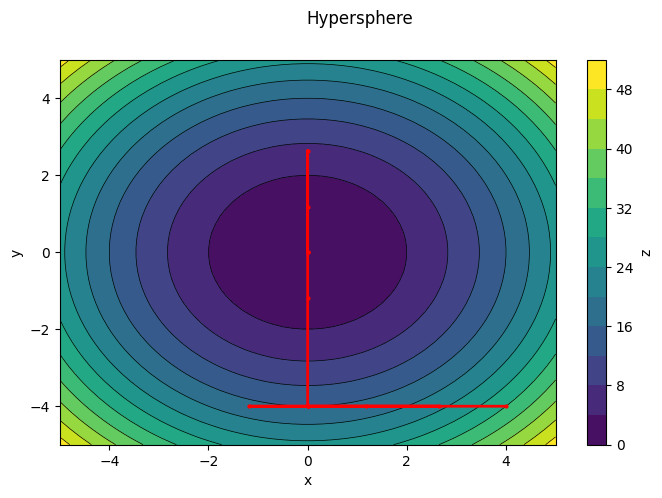

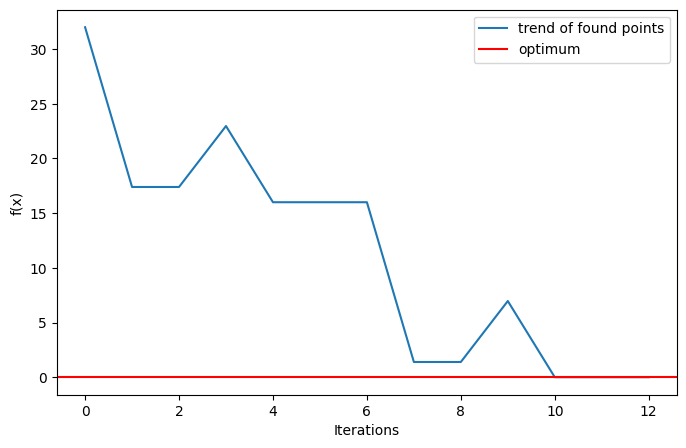

In [72]:
bench_func = bf.Hypersphere(n_dimensions=2) #TODO: try differenct benchmark functions and parameters
func = OptFun(bench_func)
print("Bounds:", func.bounds())

x_0 = [4.,-4.]  # TODO: try other suitable initial points
max_iter = 1  # TODO: try other values

result = powell(func, x_0, max_iter)
print("Best solution:", result.x)
print("Best value:", result.fun)

func.heatmap()
func.plot()

## Exercise 4/4: NELDER MEAD OPTIMIZATION

In this exercise we will focus on the Nelder Mead optimization algorithm.
Similar to the previous exercise, answer the following questions:

### Questions
- What happens when varying the parameters of the algorithm?
- How they influence the optimization process?
- The effects of these parameters is the same across different functions?
- How does this algorithm compare to the previous?

Bounds: [(-5.0, 5.0), (-5.0, 5.0)]
Best solution: [-1.696875  0.05    ]
Best value: 2.881884765625018


<Figure size 800x500 with 0 Axes>

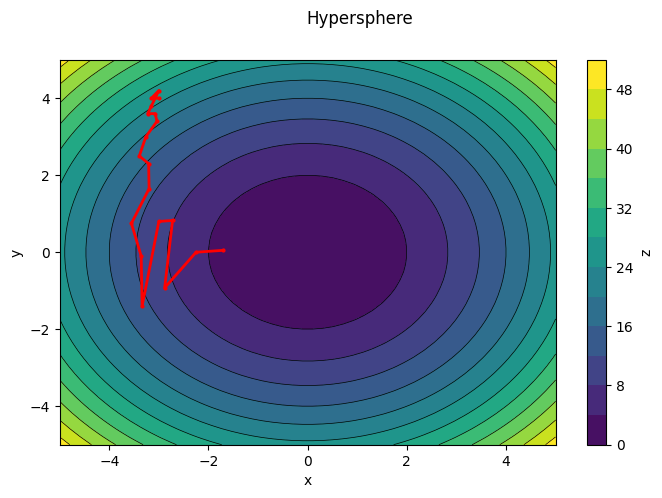

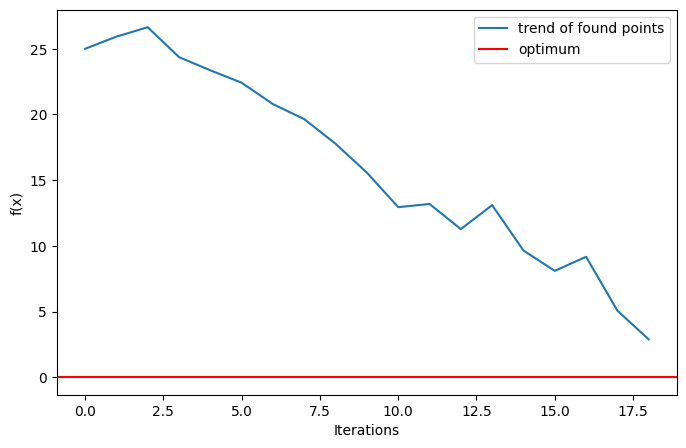

In [75]:
bench_func = bf.Hypersphere(n_dimensions=2) #TODO: try differenct benchmark functions and parameters
func = OptFun(bench_func)
print("Bounds:", func.bounds())

x_0 = [-3.,4.]  # TODO: try other suitable initial points
max_iter = 10  # TODO: try other values

result = nelder_mead(func, x_0, max_iter)
print("Best solution:", result.x)
print("Best value:", result.fun)

func.heatmap()
func.plot()

## Final questions
- How the benchmark functions influence the optimization algorithms? There is an algorithm which is always better than the other?
- The choiche of the parameters is influenced by the function to optimize? And how the algorithm are influenced by the parameters?

In [10]:
# TODO: compare the different optimization algorithms